In [ ]:

!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 247 kB/s 
     |████████████████████████████████| 16.7 MB 56.4 MB/s 


In [ ]:
!pip install geopy

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras 
import geopy 
import geopandas as gpd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import io
import os
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import mean_absolute_error

In [ ]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/fraudTrain.csv"
df = pd.read_csv(path)
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


### Deal With Lat/Lon

Lat and Long data used to create distance data for new column

In [ ]:
home_loc = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['lat'], df['long']))
merch_loc = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['merch_lat'], df['merch_long']))

In [ ]:
##adding the distance column to the data frame
df['distance'] = home_loc.distance(merch_loc)
df.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.87283


### Deal with Time

converting the date columns to pandas datetime type and Creating "Age" column from the date of birth and transaction date data

In [ ]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

In [ ]:
## adding the age column to the data frame
df['Age'] = ((df['trans_date_trans_time'] - df['dob'])/ np.timedelta64(1, 'Y')).round(0)
df.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,Age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.87283,31.0


### Prepare Data

In [ ]:
#droping columns too complicated for pandas to get dummies (system keeps crashing)
df = df.drop(columns =['trans_date_trans_time', 'dob', 'lat', 'long', 'merch_lat', 'merch_long','merchant', 'first', 'last', 'street', 'job', 'amt', 'trans_num', 'unix_time', 'city_pop' ])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   cc_num    1296675 non-null  int64  
 1   category  1296675 non-null  object 
 2   gender    1296675 non-null  object 
 3   city      1296675 non-null  object 
 4   state     1296675 non-null  object 
 5   zip       1296675 non-null  int64  
 6   is_fraud  1296675 non-null  int64  
 7   distance  1296675 non-null  float64
 8   Age       1296675 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 89.0+ MB


In [ ]:
df_k = pd.get_dummies(df, drop_first=True)


In [ ]:
df_k.head(3)

,cc_num,zip,is_fraud,distance,Age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,2703186189652095,28654,0,0.872830,31.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,630423337322,99160,0,0.272310,41.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,38859492057661,83252,0,0.975845,57.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check Target Balance to see how balanced my data is


In [ ]:
neg, pos = np.bincount(df_k['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



### Spliting the data into test and train and into target and features

In [ ]:
train_df_k, test_df_k = train_test_split(df_k, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df_k.pop('is_fraud'))
test_labels = np.array(test_df_k.pop('is_fraud'))

train_features = np.array(train_df_k)
test_features = np.array(test_df_k)

### Checking the shape of my data

In [ ]:
print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (1037340, 961)
Training labels shape: (1037340,)
Test features shape: (259335, 961)
Test labels shape: (259335,)


### Running the Model with optimization paramenters to combat over fitting and improve accuracy




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               96200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 96,301
Trainable params: 96,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12967/12967 [==============================] - 41s 3ms/step - loss: 14169191481344.0000 - accuracy: 0.9920 - precision: 0.0044 - recall: 0.0017 - auc: 0.5025 - prc: 0.0058 - val_loss: 0.0365 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0060


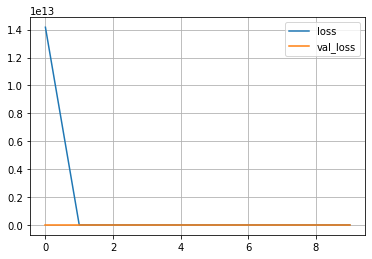

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#def make_model(metrics=METRICS, output_bias=None):
initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model.summary()

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=metrics)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=METRICS)
#Fit
hist_model = model.fit(
  train_features,
  train_labels,
  epochs=10,
  batch_size=64,
  validation_split=0.2,
)
model.save("model.h5")
print(model.evaluate(test_features, test_labels))
plot_loss(hist_model)


In [ ]:
#checking the absolute error of the model
preds = model.predict(test_features)

mean_absolute_error(test_labels, preds)

0.011349292426217154

### Please see "predictions.ipynb" file for Predictions using the model